# Predicting Gentrification
*A study into planning application features that can help to signal early warnings of gentrification*
</br></br></br></br>
`Notebook 3`</br>
Author: Mariia Shapovalova</br>
Date: April, 2023

---
## Table of Contents
Notebook 3: Merge+EDA+Model_prep
- 0.0 Introduction
- 1.0 Merge Permits and Income Datasets
- 2.0 OHE Sample Workflow
- 3.0 Grouping by Year and Census Tract
- 4.0 2 Sample T-Test
- 5.0 Multicollinearity
- 6.0 NLP Analysis


---
<center><h2 id="identifier_0">INTRODUCTION</h2><center>

This notebook:
* Merges the two datasets: permits and income data
* Separates the dataset into **test** and **remainder** sets
* Develops workflows (such as overwriting sklearn classes) to be later applied at the modelling stage and writing functions that can be then converted into Column Transformers
  * Note: some functions and classes from this notebook are not then directly used in the modelling noteboook, but nevetheless offer an explanation of how the final modelling workflow was established
* Conducts Further EDA 
* Fits intial models

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder

from functions import *

from sklearn.feature_extraction.text import TfidfVectorizer
import string

# import the nltk stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tag import pos_tag 
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\44742\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


***

### LOAD DATA

In [3]:
#load cleaned income data
income_df=pd.read_csv('../data/clean/income_cleaned.csv',index_col=0)

#load cleaned planning data
permit_df=pd.read_csv('../data/clean/permits_cleaned.csv',index_col=0)

* After cleaning up the columns some duplciate row appeared, let's drop them

In [4]:
#Expand the cell to check permit_df 
overview(permit_df)

The dataframe shape is (730511, 16)


,Data Types,Total Null Values,Null Values Percentage,Sample Value Head,Sample Value Tail,Sample Value
Column_Name,,,,,,
PERMIT_TYPE,object,0,0.0,RENOVATION/ALTERATION,ELECTRIC WIRING,ELECTRIC WIRING
REVIEW_TYPE,object,0,0.0,STANDARD PLAN REVIEW,EASY PERMIT WEB,EASY PERMIT WEB
WORK_DESCRIPTION,object,0,0.0,INTERIOR REMODELING OF EXISTING 3 D.U. PER PLA...,REPAIR SERVICE,INSTALLATION OF LOW VOLTAGE BURGLAR ALARM INTE...
CONTACT_1_TYPE,object,0,0.0,OWNER AS GENERAL CONTRACTOR,CONTRACTOR-ELECTRICAL,CONTRACTOR-ELECTRICAL
CONTACT_1_CITY,object,0,0.0,CHICAGO,CHICAGO_SUBURBS,MINOOKA
CONTACT_1_STATE,object,0,0.0,IL,OTHER,IL
CENSUS_TRACT,int64,0,0.0,220702,530503,620300
LOG_PROCESSING_TIME,float64,0,0.0,4.394449,-23.025851,-23.025851
LOG_BUILDING_FEE_PAID,float64,0,0.0,4.828314,4.317488,3.912023


In [5]:
#Expand the cell to check income_df 
overview (income_df)

The dataframe shape is (725, 14)


,Data Types,Total Null Values,Null Values Percentage,Sample Value Head,Sample Value Tail,Sample Value
Column_Name,,,,,,
Census_Tract,float64,0,0.0,10100.0,844700.0,30601.0
Mean_Income_2010,float64,0,0.0,51153.0,37440.5,50757.0
Mean_Income_2011,float64,0,0.0,46073.0,36450.5,50330.0
Mean_Income_2012,float64,0,0.0,45816.0,33392.0,49079.0
Mean_Income_2013,float64,0,0.0,47297.0,36750.0,48791.0
Mean_Income_2014,float64,0,0.0,44918.0,33411.0,49861.0
Mean_Income_2015,float64,0,0.0,47638.0,36720.0,51215.0
Mean_Income_2016,float64,0,0.0,47736.0,36913.5,52295.0
Mean_Income_2017,float64,0,0.0,50719.0,39800.5,53155.0


---
**<center><h2>MERGE<center><h2>**

* Merge **Permit_df** and **Income_df** on `Census Tract`

In [6]:
#Merge on Census_Tract
df_merged=pd.merge(permit_df,income_df,how='inner',left_on='CENSUS_TRACT', right_on='Census_Tract').drop(columns='CENSUS_TRACT')

In [7]:
#Expand the cell to check merged dataframe - df_merged
overview (df_merged)

The dataframe shape is (724869, 29)


,Data Types,Total Null Values,Null Values Percentage,Sample Value Head,Sample Value Tail,Sample Value
Column_Name,,,,,,
PERMIT_TYPE,object,0,0.0,RENOVATION/ALTERATION,ELECTRIC WIRING,ELECTRIC WIRING
REVIEW_TYPE,object,0,0.0,STANDARD PLAN REVIEW,EASY PERMIT WEB,EASY PERMIT WEB
WORK_DESCRIPTION,object,0,0.0,INTERIOR REMODELING OF EXISTING 3 D.U. PER PLA...,INSTALLATION OF (1) 30 AMP DUAL POLE BREAKER A...,INSTALLATION OF LOW VOLTAGE BURGLAR ALARM # 34...
CONTACT_1_TYPE,object,0,0.0,OWNER AS GENERAL CONTRACTOR,CONTRACTOR-ELECTRICAL,CONTRACTOR-ELECTRICAL
CONTACT_1_CITY,object,0,0.0,CHICAGO,CHICAGO,OAK BROOK
CONTACT_1_STATE,object,0,0.0,IL,IL,IL
LOG_PROCESSING_TIME,float64,0,0.0,4.394449,1.791759,-23.025851
LOG_BUILDING_FEE_PAID,float64,0,0.0,4.828314,3.688879,3.912023
LOG_ZONING_FEE_PAID,float64,0,0.0,4.317488,-23.025851,-23.025851


In [8]:
df_merged.to_csv('../data/clean/merged_df')

***
<center><h2>OHE<center><h2>

* ONE HOT ENCODING won't be applied to the dataset exported from this notebook because this would prevent from running cross validation correctly
* Instead, this section focuses on defining the workflow that can be later replicated in the modelling notebook
* Additionally, OHE is required to conduct futher EDA
* `mention data leakage`

* First Step in the modelling preparation is to conduct One Hot Encoding for the categorical columns
* Convert any relevant qualitative columns into quantitative columns
  * Cleaning process was done with ohe in mind, hence all qualitative columns, apart from Work Description, should  be ready to be one hot encoded

* Consider the number of unique categories to determine the appropriatness of OneHotEncoding

In [9]:
df_cat=df_merged.select_dtypes("object")
df_cat.nunique()

PERMIT_TYPE              7
REVIEW_TYPE             11
WORK_DESCRIPTION    559400
CONTACT_1_TYPE          25
CONTACT_1_CITY           7
CONTACT_1_STATE          4
New_Topics              10
dtype: int64

* All categorical columns, apart from 'WORK_DESCRIPTION' can be one hot encoded

In [10]:
#select all categorical columns apart from the 'WORK_DESCRIPTION' column
ohe_col=df_cat.drop(columns='WORK_DESCRIPTION').select_dtypes(include=['object']).columns
ohe_col

Index(['PERMIT_TYPE', 'REVIEW_TYPE', 'CONTACT_1_TYPE', 'CONTACT_1_CITY',
       'CONTACT_1_STATE', 'New_Topics'],
      dtype='object')

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomOneHotEncoder_CT(BaseEstimator, TransformerMixin):
    def __init__(self, **kwargs):
        self.encoder = OneHotEncoder(**kwargs)
        self.ohe_col=None
    
    def fit(self, X, y=None):

        if 'WORK_DESCRIPTION' in X.columns:
            ohe_col=X.drop(columns='WORK_DESCRIPTION').select_dtypes(include=['object']).columns
        else: 
            ohe_col=X.select_dtypes(include=['object']).columns


        self.encoder.fit(X[ohe_col])
        self.ohe_col=ohe_col
        return self
    
    def transform(self, X):
        transformed_data = self.encoder.transform(X[self.ohe_col])
        column_names = self.encoder.get_feature_names_out()
        df = pd.DataFrame(transformed_data.toarray(), columns=column_names)
        df=pd.concat([X,df],axis=1)
        df = df.drop(columns=self.ohe_col)
        return df

***
NOTE "Previous steps taken"

* Note: initally a similar result was achieved using a function applying one hot encoding. 
* However, ohe should only be applied to the trianing set, hence fit and transform methods had to be separated
* To view the intial function, please, expand the cell below

In [12]:
def ohe_cat(df,col_li):
    '''
    Use:
        Apply OHE for the specified columns only and returns a new full dataframe
    
    Inputs:
        df (pandas.DataFrame): Input DataFrame
        col_li(list): List of column names to apply OHE
    
    Returns:
        df_result(Pandas DataFrame): Result DataFrame with OHE applied to specified columns'''

    #copy dataframe 
    df_result=df.copy()

    # Iterate through each column in the input list
    for col in col_li:

        #Instantiate the encoder
        enc = OneHotEncoder(sparse=False)

        #Encode and convert it into a new DataFrame with column names including the original column name
        df_temp=pd.DataFrame(enc.fit_transform(df[[col]]),columns=[col+'_'+i for i in enc.categories_[0]])

        # Concatenate the encoded df with the existing DataFrame
        df_result=pd.concat([df_result,df_temp],axis=1)

    # Drop the original categorical columns from the result DataFrame
    df_result=df_result.drop(columns=col_li)

    return df_result

* Additionally, it was also attempted overwrite OneHotEncoder class`and create a custom OneHotEncoder
* It worked but using a custom column transformer appeared more appropriate than creating a custom OneHotEncoder because no functionality of the actual OneHotEncoding was being modified
* To view the intiial custom one hot encdoer class, please expand the cell below

In [13]:
class CustomOneHotEncoder(OneHotEncoder):
    
    # Override the fit method to fit only the specified columns and return self
    def fit(self, X, col_li, y=None):
        '''
        Inputs:
            X(DataFrame) : Input DataFrame
            col_li(list) : List of columns to apply one hot encoding to
        Output:
            fitted self
        '''

        #super() is a built-in function to call the methods of the base class.
        super().fit(X[col_li])
        return self
        
    # Override the transform method to transform only the specified columns and return a DataFrame
    def transform(self, X, col_li):
        #
        transformed_data = super().transform(X[col_li])
        columns = self.get_feature_names_out()
        df = pd.DataFrame(transformed_data.toarray(), columns=columns)
        df = pd.concat([X.drop(col_li, axis=1), df], axis=1)
        return df

#TEST
'''
my_ohe = CustomOneHotEncoder()
df_rem_ohe = my_ohe.fit(df_rem, ohe_col)
df_rem_ohe = my_ohe.transform(df_rem, ohe_col)
df_rem_ohe.head()
'''

'\nmy_ohe = CustomOneHotEncoder()\ndf_rem_ohe = my_ohe.fit(df_rem, ohe_col)\ndf_rem_ohe = my_ohe.transform(df_rem, ohe_col)\ndf_rem_ohe.head()\n'

End of NOTE "Previous steps taken"

***

In [14]:
# Create an instance of the CustomOneHotEncoder class
encode_df=CustomOneHotEncoder_CT()

# Fit the encoder to the specified columns (ohe_col) in df_rem 
encode_df.fit(df_merged)

# Transform to get a one-hot encoded version of df_rem
df_model=encode_df.transform(df_merged)

df_model.head()

,WORK_DESCRIPTION,LOG_PROCESSING_TIME,LOG_BUILDING_FEE_PAID,LOG_ZONING_FEE_PAID,LOG_OTHER_FEE_PAID,LOG_SUBTOTAL_PAID,LOG_TOTAL_FEE,LOG_REPORTED_COST,YEAR,Census_Tract,...,New_Topics_alarm,New_Topics_electrical,New_Topics_electricity upgrade,New_Topics_fence,New_Topics_garage,New_Topics_interior,New_Topics_maintenance,New_Topics_porch,New_Topics_repair,New_Topics_wrecking
0,INTERIOR REMODELING OF EXISTING 3 D.U. PER PLA...,4.394449,4.828314,4.317488,-23.025851,5.298317,5.298317,8.006368,2006,220702.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,REPLACE REAR OPEN WOOD PORCH WITH A NEW STEEL/...,3.583519,5.298317,3.912023,-23.025851,5.521461,5.521461,9.852194,2006,220702.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,DECONVERT 2ND FLOOR APARTMENT TO MAKE BUILDING...,-23.025851,4.442651,4.317488,-23.025851,5.075174,5.075174,7.600902,2006,220702.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,LOW VOLTAGE BURGLAR ALARM,2.197225,3.688879,-23.025851,-23.025851,3.688879,3.688879,5.991465,2006,220702.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,REPAIR EXISTNG TWO STORY WOOD FRAME PORCH PER ...,2.564949,4.442651,3.912023,-23.025851,4.905275,4.905275,8.342840,2006,220702.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


* Note, after one hot encoding there is still 1 qualitative column remaining - `Work_Description`
* `Work_Description` will be addressed in section `UDPATE`

###  `XXXXX`

***
<center><h3> Grouping by Cencus Tract and Year <center><h3>


**Dataframge Shape Template after the Grouping:**
| `Census Tract`| `Year` | Averaged Numerical X Feature 1 (for the given `ct` and `year`) | --- | Aggregated Qualitative Featute (for the given `ct` and `year`)| <span style="color:green">Mean Income in Year 2010 </span>| <span style="color:green">---</span>| <span style="color:green">Mean Income in Year 2021 </span>|
| --- | --- | --- | --- | --- | --- | --- |--- |
| 10100 | 2021 | XXX |XXX|XXX | XXX | XXX | XXX | 
| 10100 | 2020 | XXX |XXX |XXX |XXX | XXX | XXX | 
| 10100 | 2019 | XXX |XXX |XXX |XXX | XXX | XXX |
| --- | --- | --- |--- |--- |--- |--- |

The next step would be to merge information about each application into groups defined by census tract and year </br>
`improve`

Different approaches to quantitative and qualitative columns have to be taken when grouping the datapoints by year and census tract
* Quantitative columns (including one hot encoded columns) : take the mean
  * taking the mean is more accurate than aggregative quantitative columns because as seen in notebook 2, household counts for each census tract vary singnificantly
  * hence, it would be inaccurate
* Qualitative columns (descriptions only) : join all the descriptions together

In [15]:
def df_window_multi_type(df,year,t):

    '''
    Combines descriptions & numeric data
    Inputs:
    #df_description to only contain description columns
    '''
    #copy dataframe to avoid accidental overwriting
    df_temp=df.copy()

    if 'YEAR' not in df.columns:
        df_temp['YEAR']=df['ISSUE_DATE'].dt.year
        df_temp=df_temp.drop(columns='ISSUE_DATE')

    assert df_temp.index.is_monotonic_increasing, 'Check Indexing: Should be a simple arithmetic sequence'

    df_temp=df_temp.set_index(['Census_Tract','YEAR'])

    #to set 'YEAR' index as a column
    df_temp=df_temp.reset_index(level=1)

    #select relevant years
    #year+1 as the range end to esnure data for the current year is also included
    df_temp=df_temp[df_temp['YEAR'].isin(range(year-t,year+1))].drop(columns='YEAR')

    #instantiate the output dataframe
    df_result=pd.DataFrame()

    #select columns with distriptions
    obj_cols = df_temp.select_dtypes(include=['object']).columns
    num_cols = df_temp.select_dtypes(include=['number']).columns

    ### CAN ADD MORE FEATURES HERE ###

    #Taking averages for numeric columns
    for col in num_cols:
        df_result[col]=df_temp.groupby(level=0)[col].mean()

    #Concatenating qualitative columns
    for col in obj_cols:
        #need to keep in mind that some stings (descriptions) might be missing
        df_result[col]=df_temp.groupby(level=0)[col].apply(lambda x: ' '.join(str(i) for i in x))

    return df_result

In [16]:
#Example of the function use
#Making a prediction in 2015 based on training data for 2015 and 5 years before
df_window_multi_type(df_model,2015,5).head()

,LOG_PROCESSING_TIME,LOG_BUILDING_FEE_PAID,LOG_ZONING_FEE_PAID,LOG_OTHER_FEE_PAID,LOG_SUBTOTAL_PAID,LOG_TOTAL_FEE,LOG_REPORTED_COST,Mean_Income_2010,Mean_Income_2011,Mean_Income_2012,...,New_Topics_electrical,New_Topics_electricity upgrade,New_Topics_fence,New_Topics_garage,New_Topics_interior,New_Topics_maintenance,New_Topics_porch,New_Topics_repair,New_Topics_wrecking,WORK_DESCRIPTION
Census_Tract,,,,,,,,,,,,,,,,,,,,,
10100.0,-13.057980,3.901948,-9.984832,-21.322207,4.715007,5.056245,8.672277,51153.0,46073.0,45816.0,...,0.083333,0.138889,0.064815,0.027778,0.078704,0.027778,0.162037,0.185185,0.060185,CHANGE OF GENERAL CONTRACTOR TO PERMIT #100317...
10201.0,-14.247463,4.652362,-8.050375,-21.485932,5.137747,5.302823,8.102537,52591.0,54747.0,52577.0,...,0.062162,0.100000,0.048649,0.048649,0.075676,0.072973,0.194595,0.216216,0.054054,"REPLACE SIDING, DOORS, WINDOWS, FLOORING, REPL..."
10202.0,-9.515050,3.512482,-7.480449,-21.682292,4.878877,5.235623,8.111684,47699.0,50757.0,51070.0,...,0.042683,0.097561,0.024390,0.012195,0.140244,0.341463,0.073171,0.140244,0.067073,LOW VOLTAGE PERMIT FOR SECURITY CAMERA FAB AND...
10300.0,-14.571746,4.242420,-9.838836,-22.174687,4.912290,5.471642,9.152451,57075.0,57791.0,54026.0,...,0.089552,0.130597,0.055970,0.126866,0.085821,0.029851,0.104478,0.216418,0.111940,INSTALL LOW VOLTAGE BURGLAR ALARM. INTERIOR RE...
10400.0,-14.241811,-0.013478,-13.901277,-22.343950,1.138545,5.266144,9.518164,58457.0,60445.0,60477.0,...,0.068323,0.080745,0.009317,0.074534,0.149068,0.276398,0.046584,0.167702,0.086957,CARDINAL SUITE RENOVATION-FIRST FLOOR AS PER P...


---
**Feature Creation**

In [17]:
# Reported Cost over the number of Household

df_model['LOG_COST_PER_HOUSEHOLD']=df_model['LOG_REPORTED_COST']/df_model['Household_Count']

In [18]:
# Average Cost per one Renovation
# Average Cost per one Easy Permit

---
<center><h3>Classification Model : 2 Sample T-test<center><h3>


* A lot of one hot encoded features were created in the process
* Run 2-Sample T-test to determine which features are in fact statistically significant
* Since there are many pne hot encoded features, apply Benjamini-Hochberg correction
* 2-Sample T-test will be performed by splitting all datapoints into 'gentrification' & 'non-gentrification' sets using the previous established classification
* Years from **2006 to 2013** will be used for planning data
* Income change will be calculated from **2013 to 2021**

In [19]:
from functions import comb_change

In [20]:
def stat_test_prep(df,current_year,train_years,prediction_years):
    df_temp=df.copy()

    '''
    Returns df separated into positive and negative classes (based on gentrificaiton)
    Larger class is being shortened to match the shorter class

    '''
    # Drop the WORK_DESCRIPTION column if it exists
    if 'WORK_DESCRIPTION' in df_temp.columns:
        df_temp=df_temp.drop(columns='WORK_DESCRIPTION')

    # Extract a window of training data around the current year
    df_temp=df_window_multi_type(df_temp,current_year,train_years)

    # Calculate the income change for each individual geography over the prediction_years
    change=comb_change(df_temp,current_year,prediction_years) #comb_change - function to evaluate income change

    #use the median to create a mask separating the data into positive and negative income change classes
    median_temp=np.median(change)
    y_class_mask=[True if c>median_temp else False for c in change]

    #Prepare the dataframe by dropping the Income columns 
    df_temp=df_temp.drop(columns=get_columns_with_regex(df_temp,'Mean')) 

    #Apply the mask to separate into positive and negative classes
    df_pos_class=df_temp[y_class_mask]
    df_neg_class=df_temp[[not i for i in y_class_mask]]

    #obtain the shapes
    pos_len=df_pos_class.shape[0]
    neg_len=df_neg_class.shape[0]

    # Make sure the two classes have the same number of rows by randomly sampling from the larger class
    # This is required to run the t-test
    if pos_len>neg_len:
        n = pos_len-neg_len
        random_rows = df_pos_class.sample(n)
        df_pos_class = df_pos_class.drop(random_rows.index)
    elif neg_len>pos_len:
        n = neg_len-pos_len
        random_rows = df_neg_class.sample(n)
        df_neg_class = df_neg_class.drop(random_rows.index)

    return df_pos_class, df_neg_class

In [21]:
from scipy.stats import ttest_ind

def ttest_2(sample1,sample2):

    # Perform the 2-sample t-test
    t,p = ttest_ind(sample1, sample2)
    result=(t,p)

    return result

* Run the 2-sample t-test and store results in a dataframe
  * Loop through each column
  * Run ttest for each column
  * Store results in a dataframe 

In [22]:
#create separate dataframes for positive and negative classes 
#7 is the number of years before 2013 to take from planning data
#8 is the number of years ahead of 2013 to calculate the income change for
df_pos_class, df_neg_class=stat_test_prep(df_model,2013,7,8)

#instantiate an empty dataframe with the correct columns
results_df=pd.DataFrame({'feature':[],'corr_coef':[],'p-values':[]})

for col in df_pos_class.columns:
    #columns are the ssame in df_pos_class and df_neg_class
    res=ttest_2(df_pos_class[col],df_neg_class[col])

    #.loc[len(results_df)] to add row to the dataframe end
    results_df.loc[len(results_df)]=[col,res[0],res[1]]

* Are there any nulls?

In [23]:
#are there any nulls?
results_df.isna().sum()

feature      0
corr_coef    1
p-values     1
dtype: int64

In [24]:
#preview the null values
results_df[results_df['p-values'].isna()]

,feature,corr_coef,p-values
17,REVIEW_TYPE_DIRECT DEVELOPER SERVICES,NaN,NaN


* Note: in EDA it was established that REVIEW_TYPE_DIRECT DEVELOPER SERVICES category was only added in 2015, which explains why there is no data for it in the planning applicaiton

In [25]:
#mask where p-values not null
mask=~results_df['p-values'].isna()
results_df=results_df[mask]

p_val=np.array(results_df['p-values'])

#need to readjust given that multiple t-tests are run
from statsmodels.stats.multitest import multipletests

# apply the Benjamini-Hochberg correction

# [0] from multipletests return bool value for whether the test passed or not passed
# Pass/ not pass is determined by the readjusted p-value being less or more than 0.05
pval_pass = multipletests((p_val), method='fdr_bh')[0]
# [1] from multipletests returns the new p values
pvals_updated = multipletests((p_val), method='fdr_bh')[1]

#add these metrics to the existing dataframe
results_df.loc[:,'new_pval']=pvals_updated
results_df.loc[:,'pval_pass']=pval_pass

* `Preview the features that passed the test`

In [26]:
#filter output df to features that passed the test following the Benjamini-Hochberg correction
pval_pass=results_df[results_df['pval_pass']==True]
#features that did not pass the test
pval_not_pass=results_df[results_df['pval_pass']==False]

print('number of features that passed -',len(pval_pass))
print('number of features that did not pass -',len(pval_not_pass))
pval_pass

number of features that passed - 17
number of features that did not pass - 55


,feature,corr_coef,p-values,new_pval,pval_pass
2,LOG_ZONING_FEE_PAID,2.891366,3.950959e-03,0.017779,True
3,LOG_OTHER_FEE_PAID,2.796110,5.309674e-03,0.022488,True
5,LOG_TOTAL_FEE,4.413737,1.171221e-05,0.000163,True
6,LOG_REPORTED_COST,4.279859,2.122378e-05,0.000218,True
11,PERMIT_TYPE_NEW CONSTRUCTION,3.473035,5.452864e-04,0.003926,True
13,PERMIT_TYPE_RENOVATION/ALTERATION,2.943798,3.346174e-03,0.016062,True
19,REVIEW_TYPE_EASY PERMIT WEB,-3.383506,7.542975e-04,0.004526,True
22,REVIEW_TYPE_SELF CERT,4.381373,1.354198e-05,0.000163,True
28,CONTACT_1_TYPE_CONTRACTOR-ELECTRICAL,-2.952504,3.254350e-03,0.016062,True
32,CONTACT_1_TYPE_CONTRACTOR-PLUMBER/PLUMBING,-3.044194,2.417797e-03,0.013391,True


In [ ]:
(df_model,2013,7,8)

In [59]:
# Drop the WORK_DESCRIPTION column if it exists
df_temp=df_model.copy()


if 'WORK_DESCRIPTION' in df_temp.columns:
    df_temp=df_temp.drop(columns='WORK_DESCRIPTION')

# Extract a window of training data around the current year
df_temp=df_window_multi_type(df_temp,2021,15)

# Calculate the income change for each individual geography over the prediction_years
change=comb_change(df_temp,2010,11) #comb_change - function to evaluate income change


#LOG_REPORTED_COST	

In [63]:
df_temp

,LOG_PROCESSING_TIME,LOG_BUILDING_FEE_PAID,LOG_ZONING_FEE_PAID,LOG_OTHER_FEE_PAID,LOG_SUBTOTAL_PAID,LOG_TOTAL_FEE,LOG_REPORTED_COST,Mean_Income_2010,Mean_Income_2011,Mean_Income_2012,...,New_Topics_alarm,New_Topics_electrical,New_Topics_electricity upgrade,New_Topics_fence,New_Topics_garage,New_Topics_interior,New_Topics_maintenance,New_Topics_porch,New_Topics_repair,New_Topics_wrecking
Census_Tract,,,,,,,,,,,,,,,,,,,,,
10100.0,-12.304037,4.339456,-8.718194,-21.342093,4.863247,5.520225,9.140675,51153.0,46073.0,45816.0,...,0.104305,0.077815,0.127483,0.056291,0.049669,0.112583,0.023179,0.172185,0.231788,0.044702
10201.0,-13.824474,4.741901,-7.029399,-21.044648,5.278534,5.460483,8.490800,52591.0,54747.0,52577.0,...,0.098131,0.050234,0.105140,0.052570,0.038551,0.084112,0.077103,0.200935,0.225467,0.067757
10202.0,-11.096216,4.090064,-7.964957,-21.663953,5.013364,5.459191,8.640831,47699.0,50757.0,51070.0,...,0.091371,0.038071,0.109137,0.065990,0.043147,0.129442,0.241117,0.071066,0.154822,0.055838
10300.0,-13.270718,4.489341,-9.026395,-21.566699,5.188142,5.575207,9.154038,57075.0,57791.0,54026.0,...,0.055163,0.066478,0.121641,0.087694,0.101839,0.100424,0.038190,0.104668,0.227723,0.096181
10400.0,-12.235403,1.970188,-13.428406,-22.006039,2.766508,5.384399,9.427081,58457.0,60445.0,60477.0,...,0.036300,0.066745,0.077283,0.029274,0.077283,0.145199,0.279859,0.069087,0.152225,0.066745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843700.0,-10.532456,3.758697,-9.210077,-19.848072,4.964586,5.661195,9.229543,81933.0,136092.0,136926.0,...,0.059795,0.057517,0.080866,0.112756,0.029613,0.169134,0.252278,0.047267,0.076879,0.113895
843800.0,-12.203670,3.852768,-9.996090,-20.814707,4.410654,5.385957,8.650633,51766.0,50963.0,42772.0,...,0.077052,0.077052,0.175879,0.058626,0.026801,0.105528,0.038526,0.197655,0.135678,0.107203
843900.0,-12.144933,4.607710,-8.496493,-20.480448,5.117882,5.602597,8.970130,48229.0,45613.0,52815.0,...,0.128617,0.038585,0.165595,0.061093,0.041801,0.123794,0.070740,0.118971,0.157556,0.093248


In [60]:
cost=df_temp['LOG_REPORTED_COST']

In [61]:
len(change)

725

<AxesSubplot:xlabel='LOG_REPORTED_COST'>

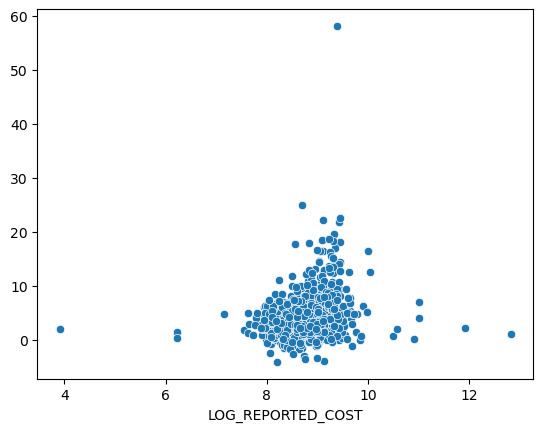

In [62]:
# Create scatter plot
sns.scatterplot(x=cost, y=change)

In [ ]:
y_class_mask=[True if c>median_temp else False for c in change]

* `Preview features that did not pass the test`

In [27]:
#preview top 15 features that did not pass the test ordering from the smallest p value
pval_not_pass.sort_values('new_pval')[:15]

,feature,corr_coef,p-values,new_pval,pval_pass
31,CONTACT_1_TYPE_CONTRACTOR-HEATING,-2.466091,0.013891,0.050008,False
24,REVIEW_TYPE_STANDARD PLAN REVIEW,2.486124,0.013139,0.050008,False
10,PERMIT_TYPE_ELECTRIC WIRING,-2.467932,0.013820,0.050008,False
46,CONTACT_1_TYPE_SELF CERT ARCHITECT,2.384166,0.017375,0.059572,False
39,CONTACT_1_TYPE_MASONRY CONTRACTOR,2.364566,0.018315,0.059940,False
26,CONTACT_1_TYPE_ARCHITECT,2.252014,0.024621,0.077075,False
40,CONTACT_1_TYPE_OWNER,2.151634,0.031757,0.091461,False
37,CONTACT_1_TYPE_EXPEDITOR,2.153628,0.031600,0.091461,False
33,CONTACT_1_TYPE_CONTRACTOR-REFRIGERATION,2.089111,0.037047,0.102592,False
65,New_Topics_fence,2.058351,0.039915,0.106439,False


* Can any of these features be merged together to form statistically significant features
* Are any of these features particularly important to the study?

In [28]:
# Instantiate a new dictionary to store any changes that could be made to the namings to combine some of the features
change_cat={}

Let's look for features that could be merged together

* Preview features referring to **architects** to determine if they can be merged together

In [29]:
results_df.loc[[True if 'ARCHI' in x else False for x in results_df['feature']],:]

,feature,corr_coef,p-values,new_pval,pval_pass
26,CONTACT_1_TYPE_ARCHITECT,2.252014,0.024621,0.077075,False
41,CONTACT_1_TYPE_OWNER AS ARCHITECT,-0.807348,0.419732,0.592563,False
42,CONTACT_1_TYPE_OWNER AS ARCHITECT & CONTRACTR,-0.563320,0.573392,0.691655,False
46,CONTACT_1_TYPE_SELF CERT ARCHITECT,2.384166,0.017375,0.059572,False


* Let' merge SELF CERT ARCHITECT into ARCHITECT 
* and CONTACT_1_TYPE_OWNER AS ARCHITECT with CONTACT_1_TYPE_OWNER AS ARCHITECT & CONTRACTR

In [30]:
#store proposed changes in a dictionary 
change_cat['SELF CERT ARCHITECT']='ARCHITECT'
change_cat['OWNER AS ARCHITECT & CONTRACTR']='OWNER AS ARCHITECT & CONTRACTR'
change_cat['OWNER AS ARCHITECT']='OWNER AS ARCHITECT & CONTRACTR'

* Preview features referring to **contractors** to determine if they can be merged together

In [31]:
results_df.loc[[True if 'CONTRACTOR' in x else False for x in results_df['feature']],:].sort_values('corr_coef')

,feature,corr_coef,p-values,new_pval,pval_pass
32,CONTACT_1_TYPE_CONTRACTOR-PLUMBER/PLUMBING,-3.044194,0.002418,0.013391,True
28,CONTACT_1_TYPE_CONTRACTOR-ELECTRICAL,-2.952504,0.003254,0.016062,True
31,CONTACT_1_TYPE_CONTRACTOR-HEATING,-2.466091,0.013891,0.050008,False
30,CONTACT_1_TYPE_CONTRACTOR-GENERAL CONTRACTOR,-1.947065,0.051914,0.133494,False
34,CONTACT_1_TYPE_CONTRACTOR-VENTILATION,-1.216988,0.224007,0.380507,False
49,CONTACT_1_TYPE_TENT CONTRACTOR,-0.473508,0.635994,0.726850,False
45,CONTACT_1_TYPE_PLUMBING CONTRACTOR,-0.410263,0.681735,0.755153,False
29,CONTACT_1_TYPE_CONTRACTOR-ELEVATOR,-0.164720,0.869210,0.903298,False
43,CONTACT_1_TYPE_OWNER AS GENERAL CONTRACTOR,0.449998,0.652847,0.734453,False
47,CONTACT_1_TYPE_SIGN CONTRACTOR,0.853180,0.393842,0.567133,False


* no obvious features to be merged together

* apply changes to the architect names in the original dataframe & repeat ohe

In [32]:
df_temp=df_merged.copy()
df_temp['CONTACT_1_TYPE']=df_merged['CONTACT_1_TYPE'].replace(change_cat)

#using custom one hot encoder regenrate the one hot encoded dataframe to run the statistical test on the updated data
encode_df=CustomOneHotEncoder_CT()

df_model=encode_df.fit_transform(df_temp)

* Re-run the statistical test

In [33]:
df_pos_class, df_neg_class=stat_test_prep(df_model,2013,7,8)

results_df=pd.DataFrame({'feature':[],'corr_coef':[],'p-values':[]})

for col in df_pos_class.columns:
    res=ttest_2(df_pos_class[col],df_neg_class[col])

    #.loc[len(results_df)] to add row to the dataframe end
    results_df.loc[len(results_df)]=[col,res[0],res[1]]

#mask where p-values not null

mask=~results_df['p-values'].isna()
results_df=results_df[mask]

p_val=np.array(results_df['p-values'])

# apply the Benjamini-Hochberg correction
pval_pass = multipletests((p_val), method='fdr_bh')[0]
pvals_updated = multipletests((p_val), method='fdr_bh')[1]

results_df.loc[:,'new_pval']=pvals_updated
results_df.loc[:,'pval_pass']=pval_pass

pval_pass=results_df[results_df['pval_pass']==True]
pval_not_pass=results_df[results_df['pval_pass']==False]
print('number of features that passed -',len(pval_pass))
print('number of features that did not pass -',len(pval_not_pass))

number of features that passed - 21
number of features that did not pass - 48


* One additional feature has now passed the test

In [34]:
results_df.loc[[True if 'ARCHI' in x else False for x in results_df['feature']],:]

,feature,corr_coef,p-values,new_pval,pval_pass
26,CONTACT_1_TYPE_ARCHITECT,3.137064,0.001776,0.009425,True
41,CONTACT_1_TYPE_OWNER AS ARCHITECT & CONTRACTR,-0.697639,0.485628,0.657044,False


* CONTACT_1_TYPE_ARCHITECT had now passed the test

In [35]:
results_df.loc[[True if 'CONTRACTOR' in x else False for x in results_df['feature']],:].sort_values('corr_coef')

,feature,corr_coef,p-values,new_pval,pval_pass
32,CONTACT_1_TYPE_CONTRACTOR-PLUMBER/PLUMBING,-3.044194,0.002418,0.011916,True
28,CONTACT_1_TYPE_CONTRACTOR-ELECTRICAL,-2.952504,0.003254,0.014430,True
31,CONTACT_1_TYPE_CONTRACTOR-HEATING,-2.466091,0.013891,0.045642,True
30,CONTACT_1_TYPE_CONTRACTOR-GENERAL CONTRACTOR,-1.947065,0.051914,0.132670,False
34,CONTACT_1_TYPE_CONTRACTOR-VENTILATION,-1.216988,0.224007,0.382440,False
47,CONTACT_1_TYPE_TENT CONTRACTOR,-0.473508,0.635994,0.731393,False
44,CONTACT_1_TYPE_PLUMBING CONTRACTOR,-0.410263,0.681735,0.758705,False
29,CONTACT_1_TYPE_CONTRACTOR-ELEVATOR,-0.164720,0.869210,0.904421,False
42,CONTACT_1_TYPE_OWNER AS GENERAL CONTRACTOR,0.449998,0.652847,0.738466,False
45,CONTACT_1_TYPE_SIGN CONTRACTOR,0.853180,0.393842,0.566148,False


* Evaluate which features to drop

In [36]:
#preview top 10 features that did not pass the test but might be still relevant for the project
pval_not_pass.sort_values('new_pval')[:10]

,feature,corr_coef,p-values,new_pval,pval_pass
39,CONTACT_1_TYPE_MASONRY CONTRACTOR,2.364566,0.018315,0.057442,False
40,CONTACT_1_TYPE_OWNER,2.151634,0.031757,0.091302,False
37,CONTACT_1_TYPE_EXPEDITOR,2.153628,0.031600,0.091302,False
33,CONTACT_1_TYPE_CONTRACTOR-REFRIGERATION,2.089111,0.037047,0.102250,False
63,New_Topics_fence,2.058351,0.039915,0.105928,False
30,CONTACT_1_TYPE_CONTRACTOR-GENERAL CONTRACTOR,-1.947065,0.051914,0.132670,False
9,PERMIT_TYPE_EASY PERMIT PROCESS,-1.912413,0.056219,0.137777,False
55,CONTACT_1_CITY_OTHER,-1.899429,0.057906,0.137777,False
54,CONTACT_1_CITY_OAK BROOK,-1.749205,0.080680,0.185565,False
61,New_Topics_electrical,-1.622283,0.105179,0.234109,False


In [37]:
pval_pass

,feature,corr_coef,p-values,new_pval,pval_pass
2,LOG_ZONING_FEE_PAID,2.891366,3.950959e-03,0.016036,True
3,LOG_OTHER_FEE_PAID,2.796110,5.309674e-03,0.020354,True
5,LOG_TOTAL_FEE,4.413737,1.171221e-05,0.000156,True
6,LOG_REPORTED_COST,4.279859,2.122378e-05,0.000209,True
10,PERMIT_TYPE_ELECTRIC WIRING,-2.467932,1.382035e-02,0.045642,True
11,PERMIT_TYPE_NEW CONSTRUCTION,3.473035,5.452864e-04,0.003762,True
13,PERMIT_TYPE_RENOVATION/ALTERATION,2.943798,3.346174e-03,0.014430,True
19,REVIEW_TYPE_EASY PERMIT WEB,-3.383506,7.542975e-04,0.004337,True
22,REVIEW_TYPE_SELF CERT,4.381373,1.354198e-05,0.000156,True
24,REVIEW_TYPE_STANDARD PLAN REVIEW,2.486124,1.313934e-02,0.045642,True


* Let's not drop
  * CONTACT_1_TYPE_MASONRY CONTRACTOR as it had a relatively strong p-value before the readjustment and just missed the test afterwards
  * Similarly let's not drop CONTACT_1_TYPE_EXPEDITOR
  * REVIEW_TYPE_DEMOLITION PERMIT, there might be very few demolitions but they are known to be relevant when evaluating gentrificaiton
  * PERMIT_TYPE_EASY PERMIT PROCESS, as this is a special process introduced in Chicago and it might be useful to evaluate its effectiveness
  * Let's drop everything else

In [38]:
MODEL_col_drop=list(pval_not_pass['feature'])

#Exclude the ones we decided were still relevant for the model
MODEL_col_drop=[i for i in MODEL_col_drop if i not in ['CONTACT_1_TYPE_EXPEDITOR','CONTACT_1_TYPE_MASONRY CONTRACTOR','REVIEW_TYPE_DEMOLITION','PERMIT_TYPE_EASY PERMIT PROCESS']]

import joblib

joblib.dump(MODEL_col_drop, '../data/interim/MODEL_drop_feature_ttest.pkl')

['../data/interim/MODEL_drop_feature_ttest.pkl']

In [39]:
#export change_cat dictionary to be applied before modelling in the next notebook
#even though we have only improved by one feature, this is a useful workflow to have established, in case in the future we want to try combining more more features

joblib.dump(change_cat, '../data/interim/MODEL_change_cat.pkl')

['../data/interim/MODEL_change_cat.pkl']

### Check for multicollinearity

In [40]:
#select dependent variable columns as they should not be part of the multicollinearity testing
col_drop_li=list(get_columns_with_regex(df_model,'Mean').columns)

#drop dependent variable columns
df_temp=df_model.drop(columns=col_drop_li)

#drop columns that did not pass ttest
df_temp=df_temp.drop(columns=MODEL_col_drop)

#drop Work Description columns
df_temp=df_temp.drop(columns='WORK_DESCRIPTION')

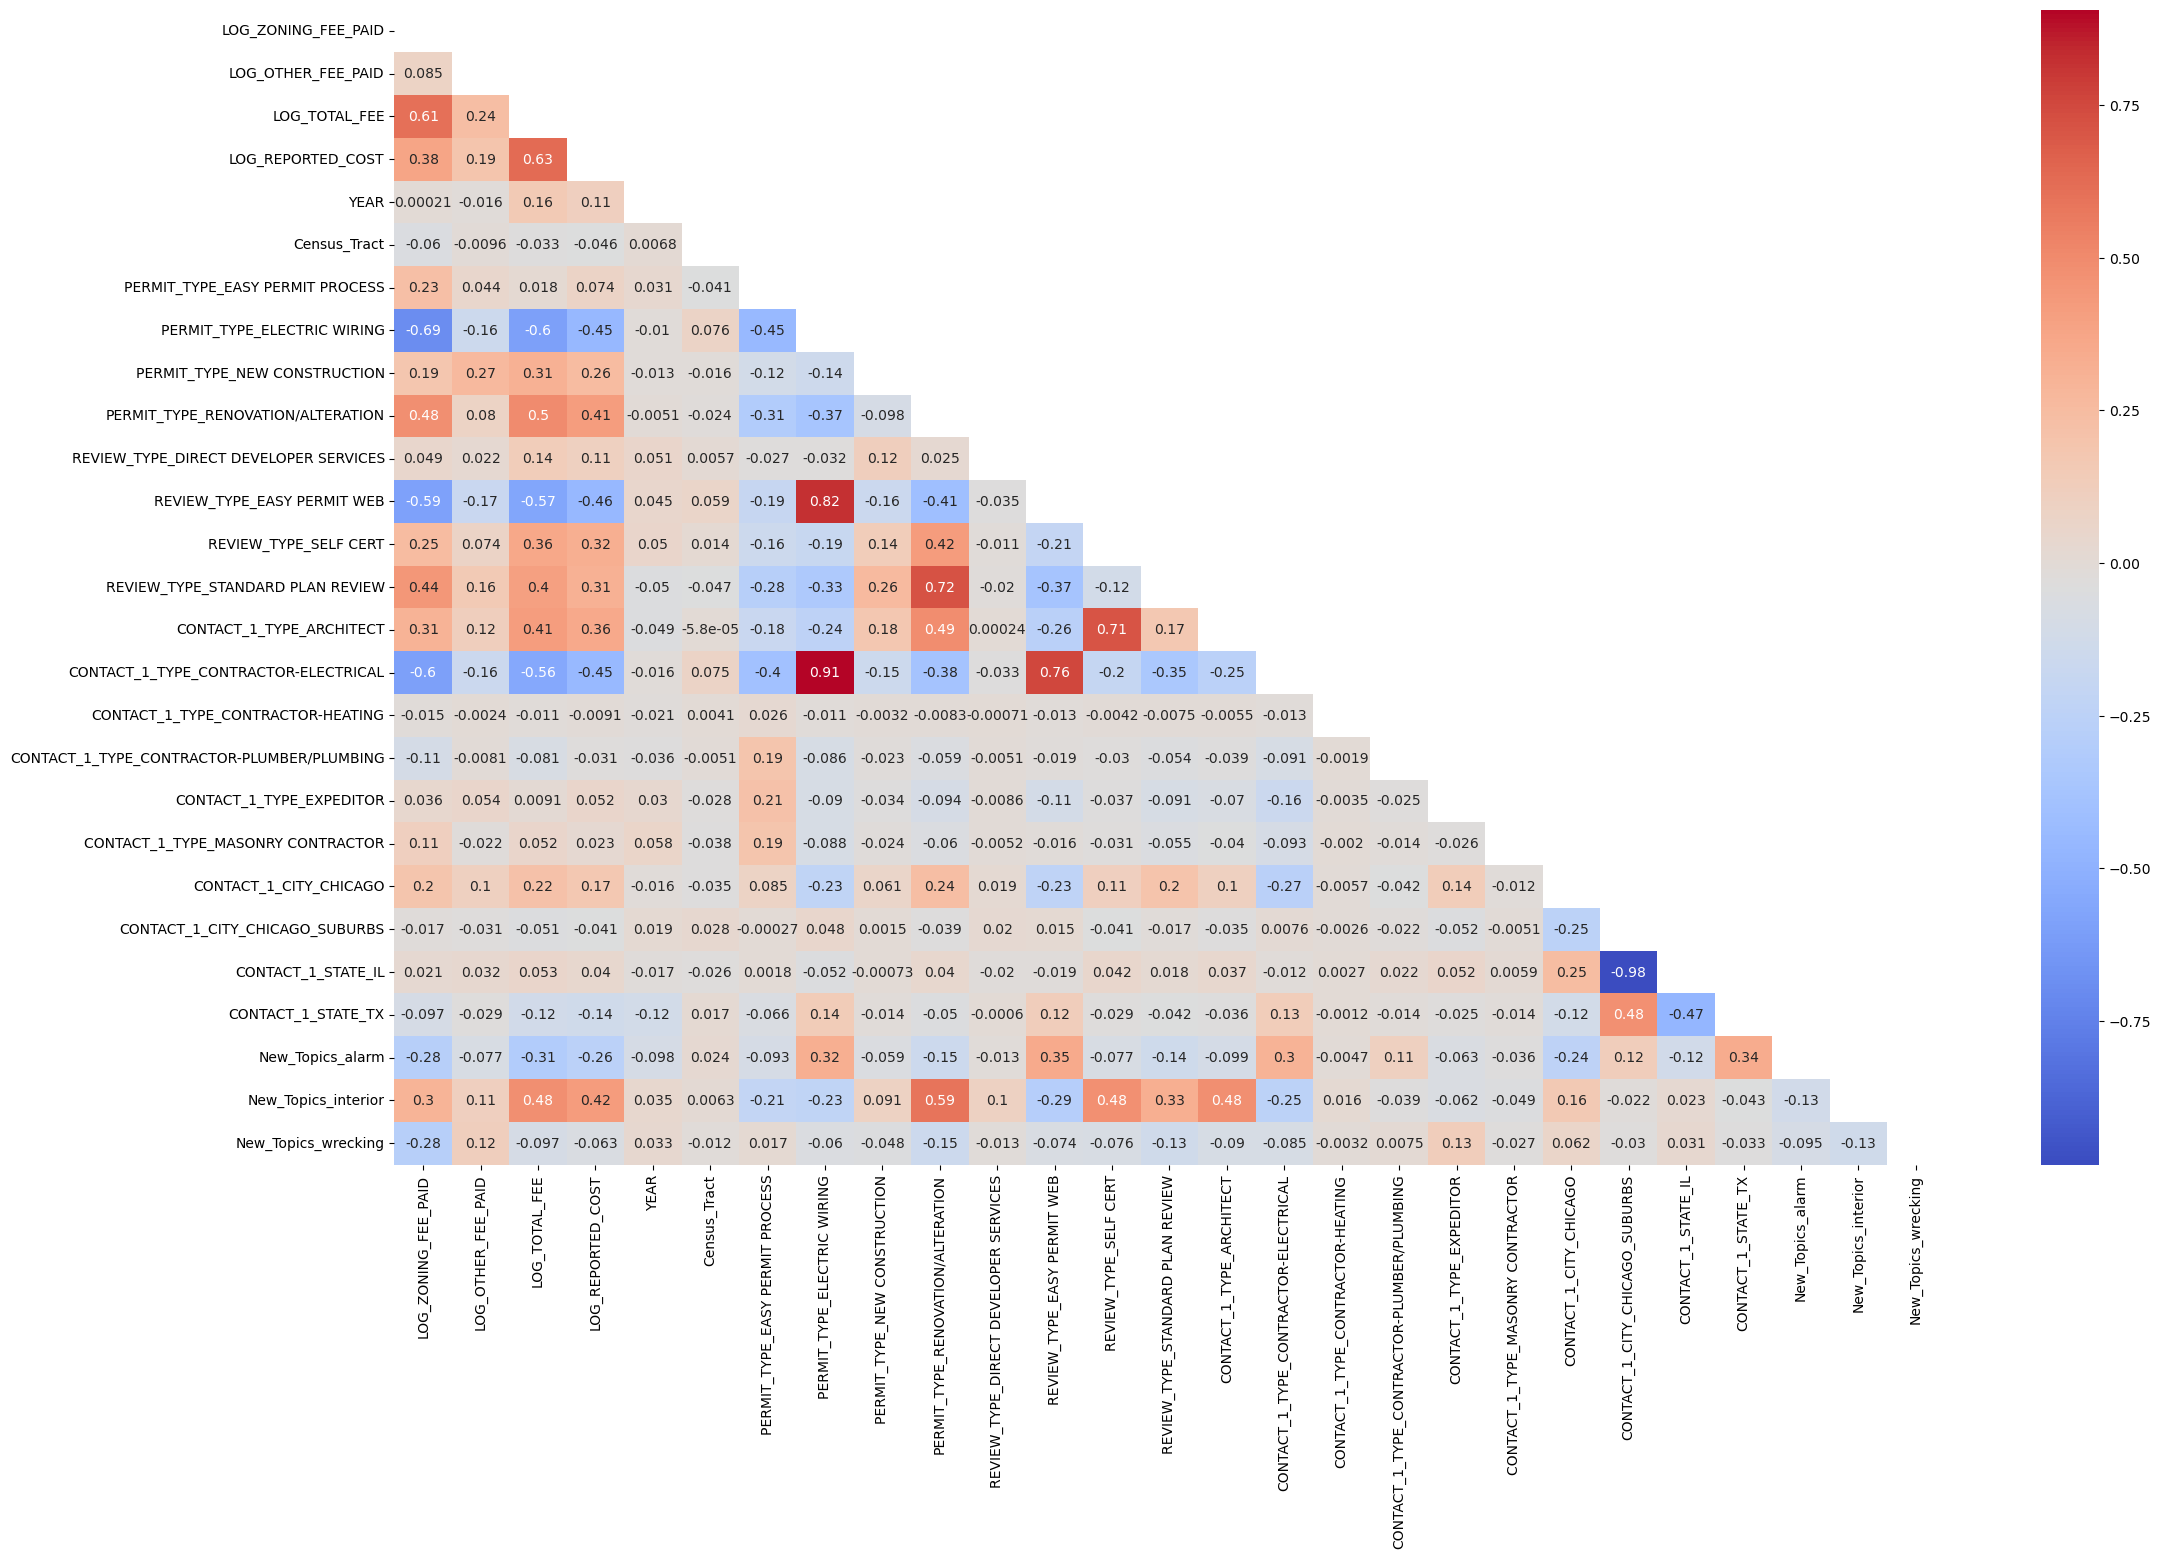

In [41]:
ind_corr=df_temp.corr()
plt.figure(figsize=(25, 15))
matrix2 = np.triu(ind_corr)
sns.heatmap(ind_corr, annot=True, mask=matrix2, cmap='coolwarm')
plt.show()

In [42]:
multi_col_drop=['CONTACT_1_TYPE_CONTRACTOR-ELECTRICAL', 'CONTACT_1_STATE_IL','LOG_ZONING_FEE_PAID','REVIEW_TYPE_EASY PERMIT WEB','REVIEW_TYPE_STANDARD PLAN REVIEW','LOG_TOTAL_FEE','REVIEW_TYPE_SELF CERT']

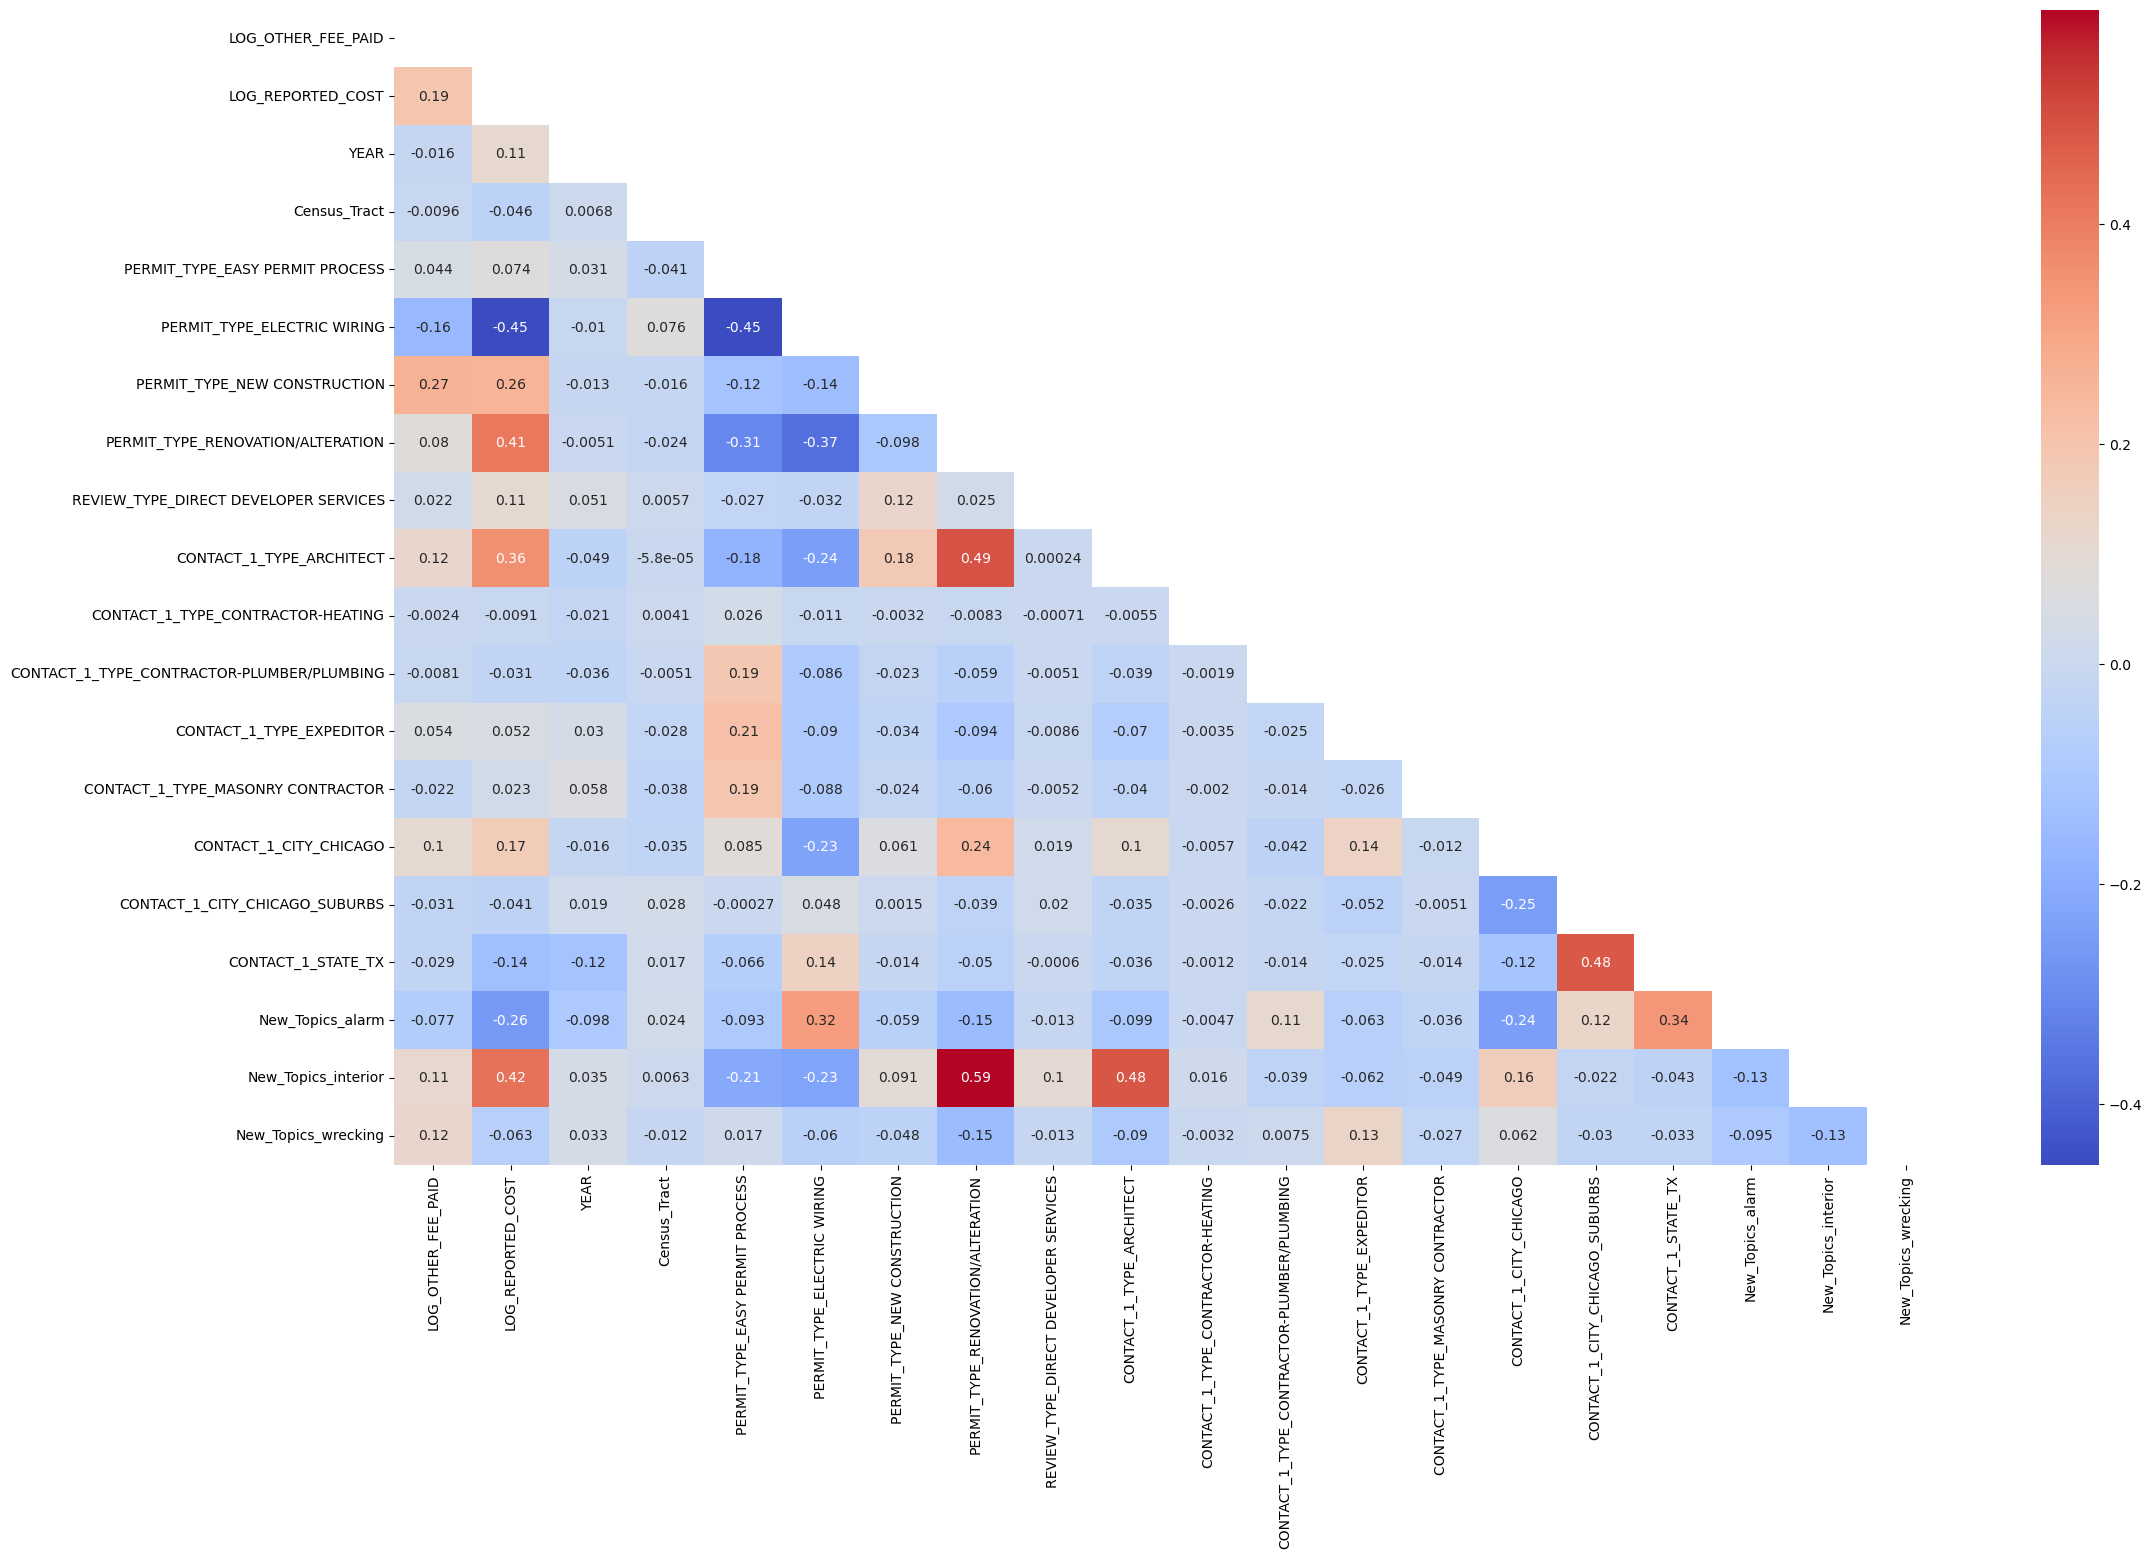

In [43]:
ind_corr=df_temp.drop(columns=multi_col_drop).corr()
plt.figure(figsize=(25, 15))
matrix2 = np.triu(ind_corr)
sns.heatmap(ind_corr, annot=True, mask=matrix2, cmap='coolwarm')
plt.show()

### **BOXPLOTS**

In [44]:
df_temp

,LOG_ZONING_FEE_PAID,LOG_OTHER_FEE_PAID,LOG_TOTAL_FEE,LOG_REPORTED_COST,YEAR,Census_Tract,PERMIT_TYPE_EASY PERMIT PROCESS,PERMIT_TYPE_ELECTRIC WIRING,PERMIT_TYPE_NEW CONSTRUCTION,PERMIT_TYPE_RENOVATION/ALTERATION,...,CONTACT_1_TYPE_CONTRACTOR-PLUMBER/PLUMBING,CONTACT_1_TYPE_EXPEDITOR,CONTACT_1_TYPE_MASONRY CONTRACTOR,CONTACT_1_CITY_CHICAGO,CONTACT_1_CITY_CHICAGO_SUBURBS,CONTACT_1_STATE_IL,CONTACT_1_STATE_TX,New_Topics_alarm,New_Topics_interior,New_Topics_wrecking
0,4.317488,-23.025851,5.298317,8.006368,2006,220702.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,3.912023,-23.025851,5.521461,9.852194,2006,220702.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,4.317488,-23.025851,5.075174,7.600902,2006,220702.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,-23.025851,-23.025851,3.688879,5.991465,2006,220702.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
4,3.912023,-23.025851,4.905275,8.342840,2006,220702.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724864,-23.025851,-23.025851,5.438079,10.998621,2006,820901.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
724865,4.317488,-23.025851,5.521461,9.472705,2007,821600.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
724866,3.912023,6.437752,7.088409,9.392662,2007,821600.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
724867,-23.025851,-23.025851,3.688879,6.214608,2007,812500.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [45]:
# Create boxplot using Seaborn
sns.boxplot(x=df_temp, y="total_bill", data=tips)

# Add title and labels to the plot
plt.title("Total Bill by Day")
plt.xlabel("Day")
plt.ylabel("Total Bill")

# Show the plot
plt.show()

NameError: name 'tips' is not defined

In [ ]:
#export the list columns with multicollinearity 
joblib.dump(multi_col_drop, '../data/interim/MODEL_milticol.pkl')

['../data/interim/MODEL_milticol.pkl']

---
### EDA for NLP
**Classification + NLP**
* Conduct EDA for the Work_Description column in the quest to exract relevant information to predict gentrification
* Evaluate if a model can be constructed based on the information extracted

* OHE was applied to most columns but there is still `Work_Description` feature that will have to be vectorized for train and test sets separately
* To group `Work_Description` column by 'Census_Tract' & 'Year':
  * Add all strings (descriptions) together into one fields
* Let's consider 2 types of descriptions:
  * overall descriptions combined and descriptions only for RENOVATION/ALTERATION, in the quest to analyse further what specific types of renovation can contribute to gentrification

In [ ]:
#select coumns useful for analysing WORK_DESCRIPTION column
df_temp=df_merged[['PERMIT_TYPE','Census_Tract','YEAR','WORK_DESCRIPTION']]
df_temp

,PERMIT_TYPE,Census_Tract,YEAR,WORK_DESCRIPTION
0,RENOVATION/ALTERATION,220702.0,2006,INTERIOR REMODELING OF EXISTING 3 D.U. PER PLA...
1,DROP,220702.0,2006,REPLACE REAR OPEN WOOD PORCH WITH A NEW STEEL/...
2,RENOVATION/ALTERATION,220702.0,2006,DECONVERT 2ND FLOOR APARTMENT TO MAKE BUILDING...
3,ELECTRIC WIRING,220702.0,2006,LOW VOLTAGE BURGLAR ALARM
4,DROP,220702.0,2006,REPAIR EXISTNG TWO STORY WOOD FRAME PORCH PER ...
...,...,...,...,...
724864,ELECTRIC WIRING,820901.0,2006,adding gfi protection to existing receptacles ...
724865,RENOVATION/ALTERATION,821600.0,2007,PORCH REPAIR PERMIT ONLY (NO INTERIOR WORK UND...
724866,EASY PERMIT PROCESS,821600.0,2007,REPLACE APPRX. 100 SHEETS OF GYP. BRD. MAXIMUM...
724867,ELECTRIC WIRING,812500.0,2007,INSTALLATION OF (1) 30 AMP DUAL POLE BREAKER A...


**Merging strings for all permit types**

* create a dataframe that contains a combined description for all the descriptions for each census tract & year

In [ ]:
df_description=pd.DataFrame()

df_description['All_Description']=df_temp.groupby(['Census_Tract','YEAR'])['WORK_DESCRIPTION'].apply(' '.join)

df_renovation=df_temp[df_temp['PERMIT_TYPE']=='RENOVATION/ALTERATION']
df_description['Renovation']=df_renovation.groupby(['Census_Tract','YEAR'])['WORK_DESCRIPTION'].apply(' '.join)

In [ ]:
#preview the descriptions
df_description

All_Description  \
Census_Tract YEAR                                                      
10100.0      2006  REBUILD PARAPET WALLS AS NEEDED AND REPLACE 12...   
             2007  Deconversion of existing 32-unit residential b...   
             2008  LIMITED REHABILITATION OF EXISTING RESIDENTIAL...   
             2009  REMOVE EXISTING DOORS WITH C LABEL DOORS, INST...   
             2010  CHANGE OF GENERAL CONTRACTOR TO PERMIT #100317...   
...                                                              ...   
844700.0     2019  THE WORK INCLUDES A DE-CONVERSION AND AN INTER...   
             2020  FIRE DAMAGE REPAIR OF EXISTING 2 DWELLING UNIT...   
             2021  THREE EXISTING WINDOWS ON THE SOUTH ELEVATION ...   
             2022  COMPLETE ROOF TEAR OFF AND REPLACEMENT WITH IN...   
             2023  A) REPAIR ELECTRICAL VIOLATIONS AS PER CITY OF...   

                                                          Renovation  
Census_Tract YEAR                                                     
10100.0      2006  Porch repair per plans and per code violations...  
             2007  Deconversion of existing 32-unit residential b...  
             2008  LIMITED REHABILITATION OF EXISTING RESIDENTIAL...  
             2009  REMOVE AND REPLACE 2 PORCHES AT EXISTING 3 STO...  
             2010  CONVERT THE THREE DWELLING UNITS INTO FOUR DWE...  
...                                                              ...  
844700.0     2019  THE WORK INCLUDES A DE-CONVERSION AND AN INTER...  
             2020  FIRE DAMAGE REPAIR OF EXISTING 2 DWELLING UNIT...  
             2021  THREE EXISTING WINDOWS ON THE SOUTH ELEVATION ...  
             2022  REPLACE THE EXISTING REAR OPEN WOOD PORCH AS P...  
             2023  SPR 2019 CBC - INTERIOR RENOVATION, REPLACE RE...  

[12518 rows x 2 columns]

In [ ]:
#define tokenizer
STOP_WORDS = stopwords.words('english')
STOP_WORDS.append('per')

def my_tokenizer(sentence):
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    listof_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in STOP_WORDS) & (len(word)>2) & (not bool(re.search('\d', word))):
            #stemmer = PorterStemmer()
            #stemmed_word = stemmer.stem(word)
            #listof_words.append(stemmed_word)
            listof_words.append(word)
        else:
            continue

    return listof_words

---
### Topics
Let's look for topics inside the Work Description Column to see if further types of applications can be established

***Topics in all Descriptions***

`3 min to run`

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

all_types=[str(x) for x in df_description['All_Description']]

#0.05 --> 5% of the documents
bagofwords = TfidfVectorizer(tokenizer=my_tokenizer,min_df=0.01, max_df=0.8)
bagofwords.fit(all_types)

words_tranformed = bagofwords.transform(all_types)
print(words_tranformed.shape)


c:\Users\44742\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(12518, 2065)


`2 min to run`

In [ ]:
# fit the LDA topic model
lda = LatentDirichletAllocation(n_components=10, max_iter=30,random_state=1,verbose=0)
lda.fit(words_tranformed)

# for each topic, print the the top 10 most representative words
words = bagofwords.get_feature_names()

print('\n')

for i, topic in enumerate(lda.components_):
    topic_words = " ".join([words[j] for j in topic.argsort()[: -11: -1]])
    print(f"Topic #{i} words: {topic_words}")



Topic #0 words: porch frame residence low voltage open single change basement family
Topic #1 words: maintenance monthly month april february march january december november july
Topic #2 words: erect frame family single residence detached addition vents low voltage
Topic #3 words: tim questions please call cust mcguiresupervising electrician att telephones tele
Topic #4 words: elevator erection unit passenger one pursuant scope elevation change sign
Topic #5 words: prevention undercabinet routed hallways stand solutions ste caissons controller wheel
Topic #6 words: sign illuminated elevation channel letters mounted internally led logo facing
Topic #7 words: solar array photovoltaic panel erect qty fences main replacement meter
Topic #8 words: spr change construction cbrc frame type cbc basement residence deck
Topic #9 words: porch low voltage alarm replacement hot heater water inspection erect


c:\Users\44742\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


---
***Topics in Renovation Permits***

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

renovation=[str(x) for x in df_description['Renovation']]

#0.01 -> 1% of the documents
bagofwords_renovation = TfidfVectorizer(tokenizer=my_tokenizer,min_df=0.01, max_df=0.8)
bagofwords_renovation.fit(renovation)

words_tranformed_renovation = bagofwords_renovation.transform(renovation)
print(words_tranformed_renovation.shape)

(12518, 832)


In [ ]:
# fit the LDA topic model
lda = LatentDirichletAllocation(n_components=10, max_iter=30,random_state=1,verbose=0)

lda.fit(words_tranformed_renovation)

# for each topic, print the the top 10 most representative words
words = bagofwords_renovation.get_feature_names()

for i, topic in enumerate(lda.components_):
    topic_words = " ".join([words[j] for j in topic.argsort()[: -11: -1]])
    print(f"Topic #{i} words: {topic_words}")

Topic #0 words: porch wood rear replace building story open basement permit inspections
Topic #1 words: antennas facility wireless communications equipment radios associated sprint cabling sector
Topic #2 words: nan levels pizza cafe highrise perimeter miscellaneous panels reconfigure conference
Topic #3 words: reviews stairway consisting modifications bathroom bedrooms bedroom mechanical floor family
Topic #4 words: space floor permit building office work alterations tenant use field
Topic #5 words: antennas equipment install site wireless tmobile previous swapping rrhs rrus
Topic #6 words: porch wood open replace rear size story repair location porches
Topic #7 words: spr cbrc type occupancy cbc construction group building story use
Topic #8 words: addition family single residence rear story floor erect deck frame
Topic #9 words: basement deconversion deconvert attic original kitchen homeowner bearing bathroom nonload


* A lot of the topics seem to be surrounding the word 'porch'
* Some topics 'antennas equipment install site wireless tmobile previous swapping rrhs rrus' and 'antennas facility wireless communications equipment radios associated sprint cabling sector' similar to electrical wiring
* One should note that while these are topics in Renovation Permits a lot of the topics appear to be maintenance related, rather than maintenance-related, rather than renovation-related
* Further analysis would be needed to determine the significance of these topics, but it is clear that there is more information that can be extracted when analyzing building permits data since the pre-described features are limited by the way data is recorded.
  

In [ ]:
#we have determined

***

Outline a worflow that can replicated later on when modelling 
* Select years relevant for the training window. For the purpose of EDA, let's stick with 2006 to 2013 for training data
* Merge all the descriptions (strings) for each census tract together 
* Vectorise descriptions for each census tract

***All Descriptions***

In [ ]:
current_year=2013
train_window=7

all_types=df_window_multi_type(df_description.reset_index(),current_year,train_window)['All_Description']
all_types=df_description['All_Description']

bagofwords = TfidfVectorizer(tokenizer=my_tokenizer,min_df=0.05, max_df=0.8)
bagofwords.fit(all_types)

words_tranformed = bagofwords.transform(all_types)
print(words_tranformed.shape)

c:\Users\44742\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(12518, 748)


*`Most occuring words in all descriptions`*

In [ ]:
#Convert matrixx to array
dense_matrix = words_tranformed.toarray()

#Convert array to a dataframe and assign words as column names
df = pd.DataFrame(dense_matrix,columns=bagofwords.get_feature_names())

words_occurence=df.sum()

words_occurence.sort_values(ascending=False)[0:10]

c:\Users\44742\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


porch          1120.775099
low             887.060699
voltage         873.555218
erect           840.653432
frame           832.109681
change          804.823035
alarm           780.176359
replacement     744.266065
single          728.043677
residence       720.978448
dtype: float64

---
***Renovation Descriptions***

In [ ]:
current_year=2013
train_window=7

renovation_words=df_window_multi_type(df_description.reset_index(),current_year,train_window)['Renovation']

bagofwords_renovation = TfidfVectorizer(tokenizer=my_tokenizer,min_df=0.01, max_df=0.8)
bagofwords_renovation.fit(renovation_words)

renovation_tranformed = bagofwords_renovation.transform(renovation_words)
print(renovation_tranformed.shape)

NameError: name 'df_window_multi_type' is not defined

*Most occuring words in `renovation` descriptions*

In [ ]:
#Convert matrixx to array
dense_matrix = renovation_tranformed.toarray()

#Convert array to a dataframe and assign words as column names
df = pd.DataFrame(dense_matrix,columns=bagofwords_renovation.get_feature_names())

words_occurence=df.sum()

words_occurence.sort_values(ascending=False)[0:10]

c:\Users\44742\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


porches      83.310197
second       52.299998
enclosed     50.354624
garage       49.224971
deconvert    43.395286
stair        42.468551
sfr          39.061268
revision     38.632214
office       38.433101
buildout     37.446669
dtype: float64

* Simple NLP models will be created in the next notebook
* Nevertheless, going further, one could use description columns to create new permit type classification
* From the previous EDA, it was apparent that permit and review types have not change significantly from at least 2010
* Creating better descriptions of permit types can help to classify different applications and improve urban policies
* By improving the descriptions of permit types, it can help policymakers to better understand the types of development occurring in a city and to develop more targeted policies.

**Could we define better permit types**